# Import modules

In [2]:
import numpy as np
import pandas as pd
import tenseal as ts
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

# Make Context

In [3]:
# Encrypt the trained model
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.global_scale = 2 ** 40
context.generate_galois_keys()

# Load dataset

In [4]:
iris = load_iris()
X, y = iris.data, iris.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
pd.DataFrame(X_train, columns=iris.feature_names).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.6,3.6,1.0,0.2
1,5.7,4.4,1.5,0.4
2,6.7,3.1,4.4,1.4
3,4.8,3.4,1.6,0.2
4,4.4,3.2,1.3,0.2


## Some Test Cases

In [6]:
encrypted_val1 = ts.ckks_vector(context, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
encrypted_val2 = ts.ckks_vector(context, [2])

# Compare encrypted values
comp_result = encrypted_val1 - encrypted_val2
comp_result.decrypt()
encrypted_val1.shape

[10]

# On Plaintext

## implement from scratch with numpy

In [7]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or n_classes == 1:
            return {'class': np.argmax(np.bincount(y)), 'depth': depth}

        # Find the best split
        best_idx, best_thr = None, None
        best_gini = 1
        for idx in range(n_features):
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left_mask = X[:, idx] <= thr
                right_mask = X[:, idx] > thr
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                gini = (n_left / n_samples) * self._gini_impurity(y[left_mask]) + \
                       (n_right / n_samples) * self._gini_impurity(y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        left_mask = X[:, best_idx] <= best_thr
        right_mask = X[:, best_idx] > best_thr

        left_tree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature_idx': best_idx,
                'threshold': best_thr,
                'left': left_tree,
                'right': right_tree,
                'depth': depth}

    def _gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, tree):
        if 'class' in tree:
            return tree['class']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict(x, tree['left'])
        else:
            return self._predict(x, tree['right'])


# Train decision tree
model = DecisionTree(max_depth=3)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


## implement with scikit-learn

In [8]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [9]:
# get the model parameters
model_params = model.get_params()
print(model_params)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


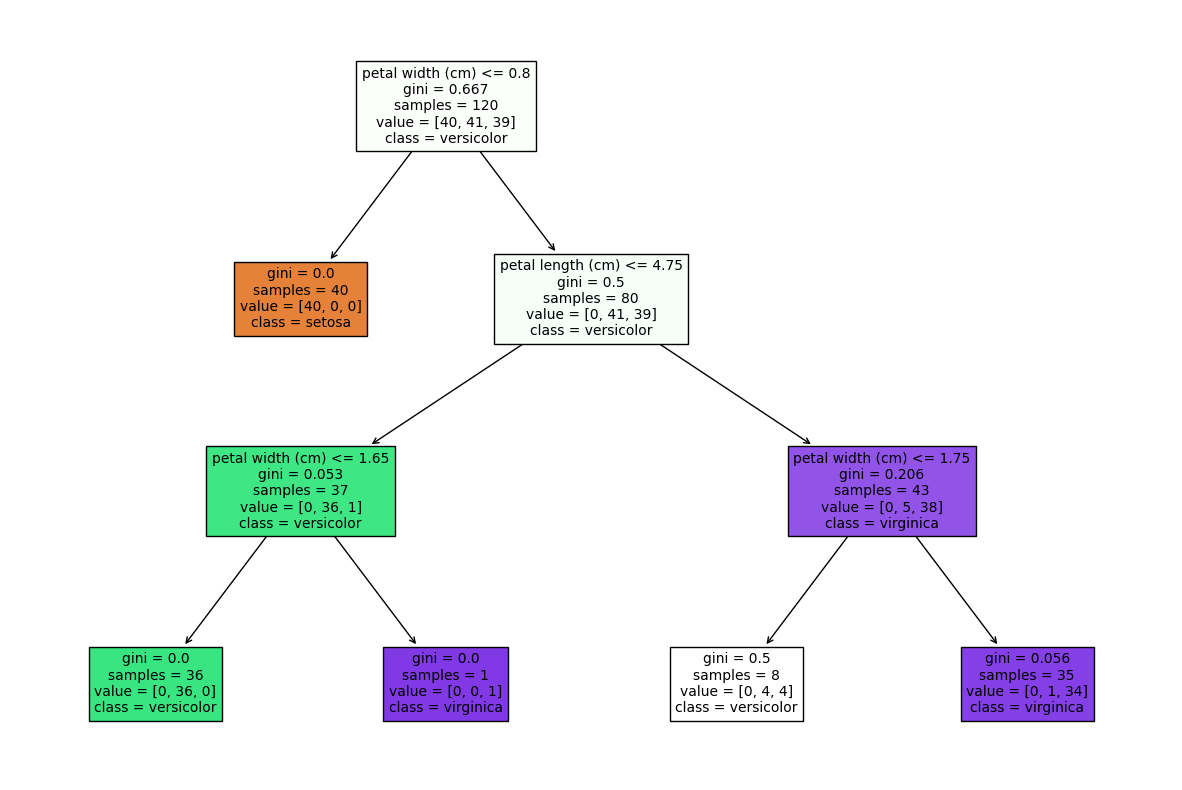

In [10]:
# visualize the tree
plt.figure(figsize=(15, 10))
tree.plot_tree(model, filled=True, fontsize=10, feature_names=iris.feature_names, class_names=list(iris.target_names))
plt.show()

# On Encrypting text

In [11]:
class EncriptDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y)) # TODO: fix to encrypt version

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or n_classes == 1:
            return {'class': np.argmax(np.bincount(y)), 'depth': depth} # TODO: fix to encrypt version

        # Find the best split
        best_idx, best_thr = None, None
        best_gini = 1
        for idx in range(n_features):
            thresholds = np.unique(X[:, idx]) # TODO: fix to encrypt version
            for thr in thresholds:
                left_mask = X[:, idx] <= thr # TODO: fix to encrypt version
                right_mask = X[:, idx] > thr # TODO: fix to encrypt version
                n_left = np.sum(left_mask) # TODO: fix to encrypt version
                n_right = np.sum(right_mask) # TODO: fix to encrypt version
                gini = (n_left / n_samples) * self._gini_impurity(y[left_mask]) + (n_right / n_samples) * self._gini_impurity(y[right_mask])
                if gini < best_gini: # TODO: fix to encrypt version
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        left_mask = X[:, best_idx] <= best_thr # TODO: fix to encrypt version
        right_mask = X[:, best_idx] > best_thr # TODO: fix to encrypt version

        left_tree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature_idx': best_idx,
                'threshold': best_thr,
                'left': left_tree,
                'right': right_tree,
                'depth': depth}

    def _gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True) # TODO: fix to encrypt version
        probs = counts / y.shape[0]
        return 1 - np.sum(probs ** 2) # TODO: fix to encrypt version

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, tree):
        if 'class' in tree:
            return tree['class']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict(x, tree['left'])
        else:
            return self._predict(x, tree['right'])

# Encrypt the dataset
encX_train = ts.ckks_tensor(context, X_train.tolist())
ency_train = ts.ckks_vector(context, y_train.tolist())
encX_test = ts.ckks_tensor(context, X_test.tolist())

# Train decision tree
tree = EncriptDecisionTree(max_depth=3)
tree.fit(encX_train, ency_train)

# Predictions
ency_pred = tree.predict(encX_test)

# Accuracy
y_pred = ency_pred.decrypt()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ValueError: object of too small depth for desired array